In [2]:
import os
import pickle
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
# *************** ESTRAZIONE DELLE FEATURES DELLE IMMAGINI ***************
# Caricamento del modello VGG16
model = VGG16()
# Ristrutturazione del modello, prendono con output quello del livello precedente al softmax
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)  
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# Estrazione delle features dalle immagini
features = {}
immagini = os.listdir('Flickr8K/Flicker8k_Images/')

for nome_img in immagini:
    # Caricamento dell'immagine da file
    img_path = 'Flickr8K/Flicker8k_Images/' + nome_img
    immagine = load_img(img_path, target_size=(224, 224))
    # Conversione della matrice di pixel in array numpy 
    immagine = img_to_array(immagine)
    # Reshape dei dati in 3 dimensioni (1 indica one sample)
    immagine = immagine.reshape((1, immagine.shape[0], immagine.shape[1], immagine.shape[2]))
    # Proprocessing dell'immagine per il modello VGG
    immagine = preprocess_input(immagine)
    # Estrazione delle features
    feature = model.predict(immagine, verbose=0)
    
    # ID dell'immagine
    img_id = nome_img.split('.')[0]
    # Memorizzazione delle features
    features[img_id] = feature

# tempo impiegato: 131m24s

In [9]:
# MEMORIZZAZIONE DELLE FEATURES, IN QUANTO E' UN'OPERAZIONE CHE IMPIEGA TANTO TEMPO    
# Memorizzazione delle features in pickle
pickle.dump(features, open('C:/Users/ricca/OneDrive/Desktop/UNI_Magistrale/Corsi/2 anno/2 semestre/DeepLearning/Lab/ProgettoDeepLearning/ImageCaption/features.pkl', 'wb'))

# Caricamento delle features da pickle
with open('C:/Users/ricca/OneDrive/Desktop/UNI_Magistrale/Corsi/2 anno/2 semestre/DeepLearning/Lab/ProgettoDeepLearning/ImageCaption/features.pkl', 'rb') as f:
   features = pickle.load(f) 
   

# *************** CARICAMENTO DELLE CAPTION DELLE IMMAGINI *************** 
with open('Flickr8K/Flickr8k_text/Flickr8k.token.txt', 'r') as f:
    captions_doc = f.read()
    

In [10]:
# Creazione del mapping tra immagine e caption
# ESEMPIO DI CAPTION NEL FILE:
# 1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
mapping = {}
for line in captions_doc.split('\n'):   #PRENDO UNA RIGA PER VOLTA
    # Split della linea con #
    tokens = line.split('#')
    if len(line) < 2:
        continue
    id_immagine = tokens[0].split('.')[0]   # viene tolta l'estensione
    if (id_immagine + '.jpg') not in immagini:  # inserisco solo le caption di cui c'è l'immagine
        continue
    caption = " ".join(tokens[1:])      # converto da lista a stringa
    caption = " ".join((caption.split('\t'))[1:]) 
    
    # Inizializza la lista se non è ancora presente
    if id_immagine not in mapping:
        mapping[id_immagine] = []
    mapping[id_immagine].append(caption)
    
len(mapping)

8091

In [11]:
# *************** PREPROCESSAMENTO DELLE CAPTION (E CREAZIONE DEL TOKENIZZATORE) ***************  
for id_immagine, captions in mapping.items():
    for i in range(len(captions)):
        # Si prende una caption per volta
        caption = captions[i]
        # Si converte tutto in minuscolo
        caption = caption.lower()
        # Si eliminano caratteri speciali, ecc. (cioè che non siano lettere maiuscole o minuscole)
        caption = caption.replace('[^A-Za-z]', '')
        # Si eliminano spazi aggiuntivi
        caption = caption.replace('\s+', ' ')
        # Si aggiunge il tag di inizio e fine caption (e si considerano solo le parole composte da minimo due lettere)
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
        captions[i] = caption


all_captions = []
for id_immagine in mapping:
    for caption in mapping[id_immagine]:
        all_captions.append(caption)
        

# Tokenizzazione del testo
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
dimensione_vocabolario = len(tokenizer.word_index) + 1  # word_index è il numero di parole univoche che abbiamo

# Massima lunghezza della caption disponibile (per il padding successivo) 
max_lunghezza_caption = max(len(caption.split()) for caption in all_captions)

In [15]:
# *************** SPLITTING DATA IN TRAINING E TEST SET (COME INDICATO NEI FILE) *************** 
with open('Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt', 'r') as f:
    training_set_doc = f.read()

training_set = []
for line in training_set_doc.split('\n'):   #PRENDO UNA RIGA PER VOLTA
    id_immagine = line.split('.')[0]   # viene tolta l'estensione
    if id_immagine not in mapping:
        continue
    training_set.append(id_immagine)
    
    
with open('Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt', 'r') as f:
    test_set_doc = f.read()

test_set = []
for line in test_set_doc.split('\n'):   #PRENDO UNA RIGA PER VOLTA
    id_immagine = line.split('.')[0]   # viene tolta l'estensione
    if id_immagine not in mapping:
        continue
    test_set.append(id_immagine)

In [16]:
# Creazione di un data generator per dividere i dati in batch (ed evitare di avere un crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0        # tiene conto del numero di id analizzati
    while 1:    # viene effettuato un ciclo per tutte le immagini
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # Viene considerata ogni caption singolarmente
            for caption in captions:
                # Codifica della sequenza
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split della sequenza nella coppia (X,Y) 
                # (con le X prediciamo le Y, aggiungendo alla X la parola predetta al passo precedente)
                # startseq girl going into wooden building endseq
                #        X                                       Y
                # startseq                                       girl
                # startseq girl                                  going
                # startseq girl going                            into
                # ...........
                # startseq girl going into wooden building       endseq
                for i in range(1, len(seq)):
                    # split nella coppia input e output
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence (si deve avere una dimensione comune)
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0] #restituisce una lista (perchè possiamo passare più elementi), ma a noi interessa solo il primo
                    # encode output sequence (converte in one-hot encoding)
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    # Memorizzazione delle sequenze
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y     # produce una sequenza di valori
                X1, X2, y = list(), list(), list()
                n = 0

# Modello

In [20]:
# *************** CREAZIONE DEL MODELLO *************** 
# ENCODER MODEL
# IMAGE FEATURE LAYER
inputs1 = Input(shape = (4096,))  # dipende dall'output del VGG
fe1 = Dropout(0.4)(inputs1)     # permette di eliminare alcuni neuroni della rete con probabilità 0.4
fe2 = Dense(256, activation = 'relu')(fe1)
# SEQUENCE FEATURE LAYER
inputs2 = Input(shape = (max_lunghezza_caption,))
se1 = Embedding(dimensione_vocabolario, 256, mask_zero = True)(inputs2)  # abbiamo il padding
se2 = Dropout(0.4)(se1)
  = LSTM(256)(se2)

# DECODER MODEL
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(dimensione_vocabolario, activation = 'softmax')(decoder2)
# output è un one-ho encoding

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

print(model.summary())

# Plot del modello
plot_model(model, show_shapes = True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 34, 256)              2172160   ['input_9[0][0]']             
                                                                                                  
 dropout_6 (Dropout)         (None, 4096)                 0         ['input_8[0][0]']             
                                                                                            

In [28]:
# *************** TRAINING DEL MODELLO *************** 
epochs = 5
batch_size = 100
steps = len(training_set) // batch_size

for i in range(epochs):
    # Creazione del data generator
    generator = data_generator(training_set, mapping, features, tokenizer, max_lunghezza_caption, dimensione_vocabolario, batch_size)
    # Fit del modello per ogni epoca
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
# Salvataggio del modello
model.save('C:/Users/ricca/OneDrive/Desktop/UNI_Magistrale/Corsi/2 anno/2 semestre/DeepLearning/Lab/ProgettoDeepLearning/ImageCaption/best_model.h5')

60/60 [==============================] - 2068s 34s/step - loss: 3.1537


c:\Users\ricca\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model.save('C:/Users/ricca/OneDrive/Desktop/UNI_Magistrale/Corsi/2 anno/2 semestre/DeepLearning/Lab/ProgettoDeepLearning/ImageCaption/best_model.keras')

In [30]:
# *************** GENERAZIONE DELLE CAPTION PER L'IMMAGINE ***************
# Trasformazione dell'index in parola
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:   # integer è stato predetto dal modello, quindi se index è uguale ad integer devo ritornare la parola corrispondente
            return word
    return None


# Generazione della caption per l'immagine
def predict_caption(model, image, tokenizer, max_length):
    # Aggiunta del tag di inizio
    in_text = 'startseq'
    # Iterazioni per tutta la massima lunghezza della sequenza
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad della sequence
        sequence = pad_sequences([sequence], max_length)
        # Predizione della parola successiva
        yhat = model.predict([image, sequence], verbose=0) #non si vuole spiegare niente
        # Si prende l'index con la più alta probabilità
        yhat = np.argmax(yhat)
        # Si converte da index a parola
        word = idx_to_word(yhat, tokenizer)
        # Se la parola non è stata trovata si termina
        if word is None:
            break
        # Si appende la parola all'input per generare la parola successiva
        in_text += " " + word
        # Termina se si trova il tag di fine
        if word == 'endseq':
            break
      
    return in_text

In [39]:
# *************** VISUALIZZAZIONE DEI RISULTATI ***************
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = 'Flickr8K/Flicker8k_Images/' + image_name
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Attuale---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_lunghezza_caption)
    print('--------------------Predetta--------------------')
    print(y_pred)
    plt.imshow(image)


---------------------Attuale---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predetta--------------------
startseq two dogs are playing with each other endseq


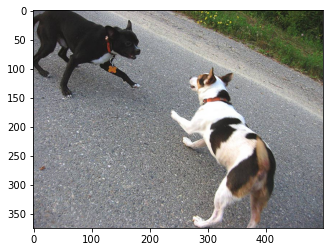

In [33]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Attuale---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predetta--------------------
startseq girl in red dress is sitting on the grass endseq


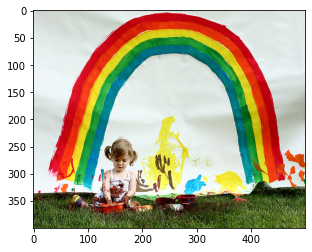

In [34]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Attuale---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predetta--------------------
startseq two men in red clothes are walking in the snow endseq


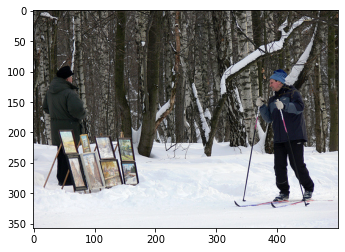

In [35]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Attuale---------------------
startseq three people drive atvs endseq
startseq three people on atvs in brown field turn their heads to look at the camera endseq
startseq three people on atv 's outside endseq
startseq three people on four wheel atv 's in field endseq
startseq three people ride their four wheelers through the field endseq
--------------------Predetta--------------------
startseq two people are riding atvs in the grass endseq


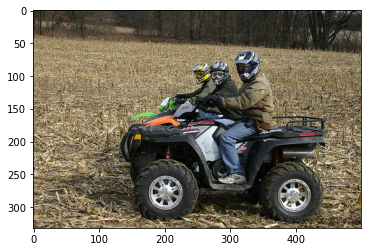

In [36]:
generate_caption("109823394_83fcb735e1.jpg")

---------------------Attuale---------------------
startseq black and white dog with green collar stands in front of sign endseq
startseq dog is jumping into pool for swim competition endseq
startseq dog jumping off dock into pool of water endseq
startseq dog walks across puddle of water in las vegas endseq
startseq the furry black and white dog is running through shallow pool endseq
--------------------Predetta--------------------
startseq black dog is jumping into the pool endseq


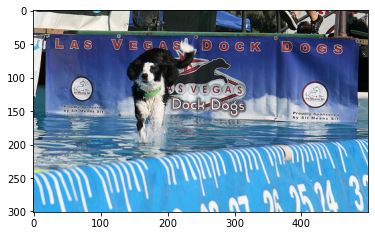

In [37]:
generate_caption("3044359043_627488ddf0.jpg")

---------------------Attuale---------------------
startseq three girls do back flips and cartwheels in the surf endseq
startseq three girls do handstands at the beach endseq
startseq three girls doing back flips on the beach endseq
startseq three little girls cartwheel in the ocean endseq
startseq three young girls playing on the beach endseq
--------------------Predetta--------------------
startseq the girl in the bathing shorts is jumping on the beach endseq


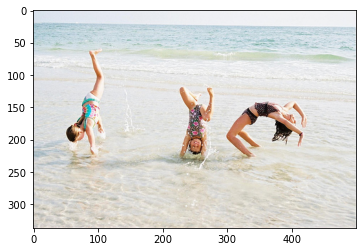

In [38]:
generate_caption("3747543364_bf5b548527.jpg")